# PD3: Building a MIDI Synth in Python

Welcome to the third PD assignment for Purdue AIM! This assignment has three purposes:
1. To get you familiar with MIDI and its attributes.
2. To teach you how to convert MIDI to sound.
3. To get you to talk and collaborate with your peers.

In this assignment, you will:
1. Learn how to synthesize simple types of waves.
2. Learn how to create MIDI data using pretty_midi.
3. Create a synthesizer which turns MIDI data into sound.
4. Share songs with others and collaborate!
5. Modify your synths to do interesting things.

Note that in this tutorial, we do not use any synthesis libraries. We do all the synthesis ourselves! 

If you ever need more information/help in text format, you can use the tutorials from MA39000/ECE39595DSL: The Data Science Labs (Fourier Analysis), which is where some of this content was derived from. *https://thedatasciencelabs.github.io/DSLab_Fourier/index.html*

You can also use the ECE 301 textbook *Signals and Systems* by Alan V. Oppenheim and Alan S. Willsky for more information on how signals work.

Finally, if this is interesting to you, the upcoming PD selective on signal processing might be interesting for you!

In [56]:
import pretty_midi
import numpy as np
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio

sr = 44100  # Sample rate

# Code to visualize the DFT of a signal
def visualize(dft_input, sr):
    t = np.linspace(0, len(dft_input) / sr, len(dft_input))
    plt.plot(t, dft_input)
    plt.xlabel("Time (s)")
    plt.show()

    # calculate the DFT
    window = np.hanning(len(dft_input))
    windowed_input = dft_input * window
    dft = np.fft.rfft(windowed_input)

    # get the amplitude spectrum in decibels
    amplitude = np.abs(dft)
    amplitude_db = librosa.amplitude_to_db(amplitude, ref=np.max)

    # get the frequency bins
    frequency = librosa.fft_frequencies(sr=sr, n_fft=len(dft_input))
    plt.plot(frequency, amplitude_db)
    plt.xlabel("Frequency (Hz)")
    plt.xlim(20, 10 ** 4)
    plt.ylabel("Amplitude (dB)")
    plt.xscale("log")


# Part 1: Synthesis of sound

To start, we are going to synthesize some simple types of waves.

The most simple type of wave is a (co)sine wave, e.g. $x(t)=\cos{(2\pi f t)}$, where $t$ is the time value, $f$ is the fundamental frequency, and $x(t)$ is the output.
(Co)sine waves are simple because their Fourier transforms are single peaks; e.g. $X(j\omega)=\pi(\delta(\omega-2\pi f)+\delta(\omega + 2\pi f))$, which looks like two peaks at frequencies $f$ and $-f$.

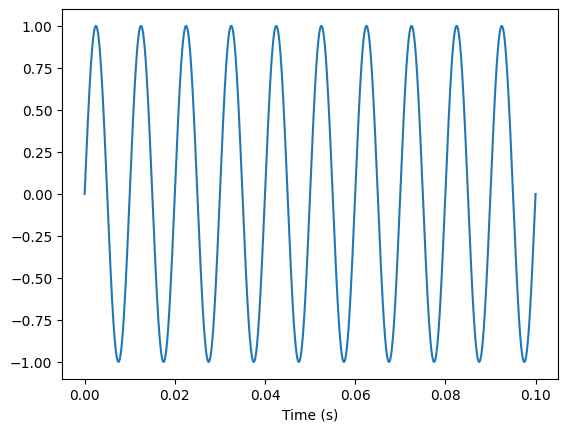

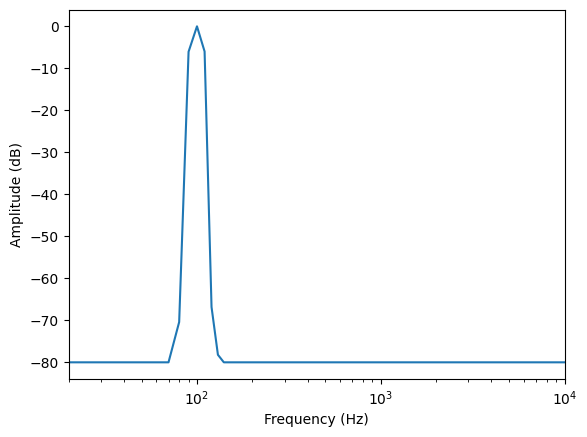

In [60]:
def sine(freq, time, sr=sr):  # Synthesizes a sine wave with frequency freq, length time, and sample rate sr
    t = np.linspace(0, time, int(time * sr))  # Calculates the time array
    out = np.sin(2 * np.pi * freq * t)
    return out


sine_out = sine(100, 0.1)
visualize(sine_out, sr)
Audio(sine_out, rate=sr)

The next type of wave we are going to plot is the sawtooth (saw) wave. In the time domain it kind of looks like a periodic linear function:
$x(t)=f(t\,\textrm{mod}\,\frac{1}{f})$
This may not seem useful at first glance, but this is periodic with period $\frac{1}{f}$, which makes our actual frequency $f$.
The Fourier transform of a saw wave has much higher harmonics than most sine-like waves (a sine wave has 0). If you want an equation of the Fourier transform, you can convert the saw wave's Fourier series (found here: https://lpsa.swarthmore.edu/Fourier/Series/ExFS.html) to a Fourier transform. The important thing to remember is that there are peaks in the amplitude at every integer multiple of the fundamental frequency.

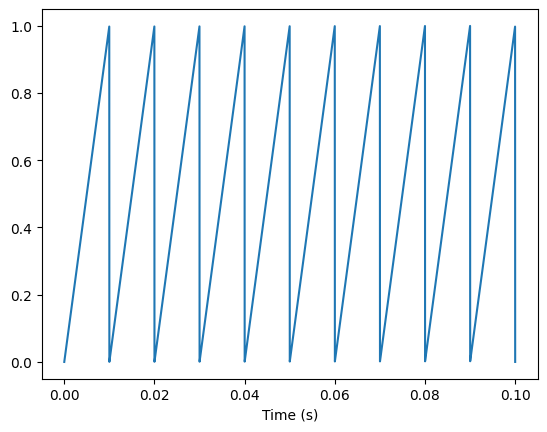

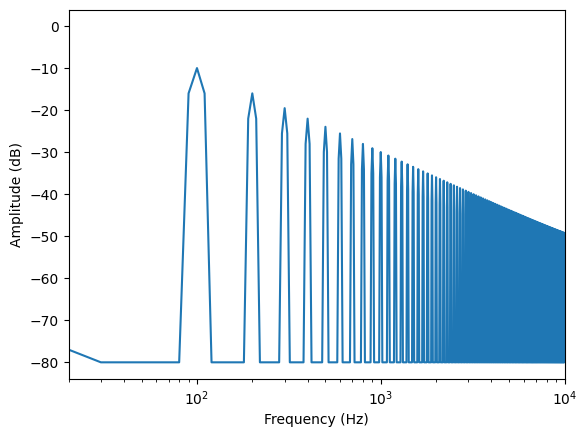

In [61]:
def saw(freq, time, sr=sr):  # Synthesizes a sawtooth wave with frequency freq, length time, and sample rate sr
    t = np.linspace(0, time, int(time * sr))  # Calculates the time array
    out = freq * np.fmod(t, 1 / freq)
    return out


saw_out = saw(100, 0.1)
visualize(saw_out, sr)
Audio(saw_out, rate=sr)

The final type of wave we will plot here is a periodic square wave, with the formula:
$x(t)=\begin{cases}
1,\,\,t\,\textrm{mod}\,\frac{1}{f} < \frac{T}{2}\\
-1,\,\,t\,\textrm{mod}\,\frac{1}{f} \geq \frac{T}{2}
\end{cases}\,\,\,\,$, where $T$ (the period of the wave) $=\frac{1}{f}$.
Its Fourier transform is a periodic sinc function. You can refer to a Signals and Systems textbook to find the explicit formula. The important thing to remember is that there are peaks in the amplitude at every odd integer multiple of the fundamental frequency.

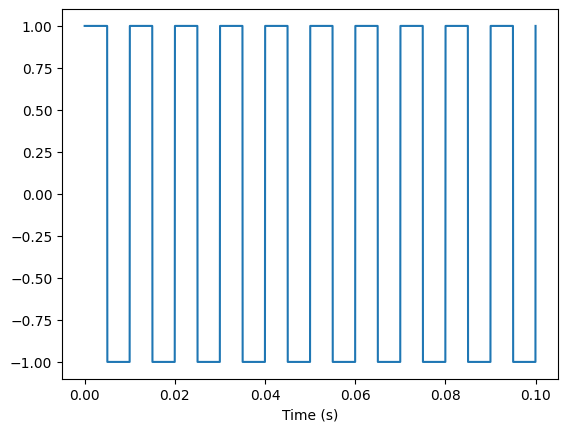

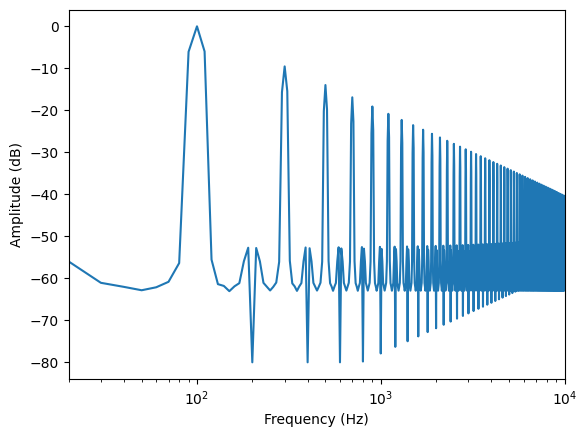

In [63]:
def square(freq, time, sr=sr):  # Synthesizes a square wave with frequency freq, length time, and sample rate sr
    t = np.linspace(0, time, int(time * sr))  # Calculates the time array
    out = np.copy(t)
    for i in range(len(t)):
        val = t[i]
        modded_val = np.fmod(val, 1 / freq)
        if modded_val < 1 / (2 * freq):
            out[i] = 1
        else:
            out[i] = -1
    return out


square_out = square(100, 0.1)
visualize(square_out, sr)
Audio(square_out, rate=sr)

# Part 2: MIDI Synthesis

In this next part we are going to learn about MIDI, its components, and how to work with it.

MIDI is a representation of music that does not generally store the physical specifics of the sound itself; rather, it's more similar to a score, where note numbers and velocities are stored in lieu of raw frequency information.

MIDI has an information hierarchy that generally looks like this:

- Instrument (stores name, all notes, more information); for each instrument, the following is stored:
    - Program type (not usually used in modern days, stores what should be used to re-synthesize audio)
    - Notes to be played; for each note, the following is stored:
        - Note number (60 = middle C(4), add 1 = go up one semitone, remove 1 = go down one semitone)
        - Start time
        - End time
        - Velocity (how hard the note should be played; 0 = minimum, 127 = maximum, generally more velocity = more harmonics when rendered)
    - MIDI CC messages (control messages), including:
        - Sustain/sostenuto pedals for pianos
        - Breath control for wind instruments
        - Articulation/pitch bend for string and synth instruments
        - User-definable messages and more!

To visualize your MIDI in a human-readable format (e.g. not with code), you can use your favorite DAW or music composition application. If you don't have one, a great free one is MuseScore: https://musescore.org/en

Let's make a MIDI file now. To start, let's initialize a pretty_midi object to store our information, as well as an instrument:

In [ ]:
midi = pretty_midi.PrettyMIDI()
inst = pretty_midi.Instrument(
    program=1)  # Program is for General MIDI program numbers; 1 = Grand Piano; you can generally ignore this

Now let's make a few notes to store:

In [ ]:
note_list = []
note_list.append(pretty_midi.Note(velocity=100, pitch=pretty_midi.note_name_to_number('C4'), start=0, end=1))
note_list.append(pretty_midi.Note(velocity=100, pitch=pretty_midi.note_name_to_number('E4'), start=0, end=1))
note_list.append(pretty_midi.Note(velocity=100, pitch=pretty_midi.note_name_to_number('G4'), start=0, end=1))

Now let's add these notes to our instrument:

In [ ]:
for note in note_list:
    inst.notes.append(note)

And finally let's add this instrument to our pretty_midi object:

In [ ]:
midi.instruments.append(inst)

If you want you can write the MIDI file to disk using the following command and open it in something else... or you can just take my word for it that it works.

In [ ]:
# midi.write('INSERT FILE PATH HERE')

# Part 3: Making a basic MIDI synthesizer

Here's the part of this tutorial where you come in. You are going to make a basic MIDI synthesizer which takes in a MIDI file and outputs some audio which represents the notes in the MIDI file.
If this seems like a daunting task to you, don't fear! Most of the hard work has already been done for you. You just have to fill in some important bits.

We've provided some sample code and pseudocode for you below. Your task is to fill in the missing bits to get audio out.

In [ ]:
# Note: you can read in MIDI files as pretty_midi objects for testing with pretty_midi.PrettyMIDI('FILE_PATH')

def create_midi(note_list):
    midi = pretty_midi.PrettyMIDI()
    inst = pretty_midi.Instrument(program=1)
    for note in note_list:
        inst.notes.append(note)
    midi.instruments.append(inst)
    return midi


def play_midi(midi: pretty_midi.PrettyMIDI, sr=44100):
    arr = np.zeros(0)
    # Your code starts here.
    #
    # The exact implementation of your code may differ, but generally, you should do these things in order:
    # 1. Set arr to be big enough to hold all the audio information in the MIDI file, or be prepared to append as needed.
    # 2. For each note in the MIDI file, synthesize its audio using one of the waves above (or your own synth).
    # 3. Add these waves into the appropriate part of arr. You can play multiple waves at once by adding their respective array elements, and can
    #    play one wave after another by placing the first wave's elements before the second's index-wise.
    # Generally if you've done this efficiently you shouldn't use more than ~20 lines of code.
    #
    # When your code is done, you should be able to:
    # - Play notes at the same time
    # - Play sequential notes sequentially
    # - Play notes at the correct time and pitch according to the MIDI file
    # - You don't have to worry about velocity... for now.
    return Audio(arr, rate=sr)

Reach out early if you need help with this part, because parts 4 and 5 depend on it!

# Part 4: Collaboration

This part should be a nice break from part 3! For this part, your goal is to collaborate with your team members!

For this task, you have several requirements, which you should perform in order:
1. Make a MIDI file using pretty_midi using code. Put some MIDI notes in the file; if you're feeling creative you can try to write a song!
2. Write the file to disk using the code above.
3. In Microsoft Teams, exchange MIDI files with at least 2 people.
4. Modify their MIDI files in some way using pretty_midi, all in Python.
5. Send each person back their MIDI files.
6. When you receive your MIDI files back, give the other person feedback on the changes they made to your file, making at least one positive comment.
7. Copy the MIDI files you made, received, and sent (all versions) into this folder for submission.
8. Write a paragraph summary of the feedback you gave and received during this task below.

*Write your feedback paragraph here*

# Part 5: Innovation

For this part, your goal is to improve something about your synthesizer that is not one of the existing requirements.

For this part, you should:
- Copy the methods you intend to modify for your synthesizer to the below box
- Edit them to be better than your implementation above
- Write a few sentences in the Markdown box below explaining what you did

Here are some ideas of what you could do if you need them:
- You may have noticed that with the above code, there is popping whenever you start or stop playing a wave. This is due to the speakers trying to instantaneously respond to the wave signal. To fix this, you can create attack and release envelopes which gradually fade in and out the sound. Make parameters for these as command line arguments.
- Add arguments to change what type of wave is synthesized based on the program number of the instrument.
- Add a filter/EQ to your wave(s) using some kind of processing library in order to make it sound different.
- Make some kind of collaborative feature which allows multiple people to contribute to the making of sound.

There are no right answers here, but there are definitely stronger and weaker answers (just like in research)! Modifying your synth in a way that is new mimics the process of actually doing research with any team (including this one), because you are actively trying to generate new knowledge/tools.

*Explain what you did to improve your synthesizer in this box.*